In [1]:
## Import relevant libraries
import os
import glob
import sys
sys.path.append('../../activedrops')

## Including ourselves
import pivdrops
pivdrops.set_plotting_style()

#### K401/Kif3-mVenus-Avitag ActiveDROPS

/Users/dalarios/git/activedrops/code/exploratory/../../activedrops/pivdrops.py:316: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ts = pd.concat([df_ts, new_row], ignore_index=True)
/Users/dalarios/git/activedrops/code/exploratory/../../activedrops/pivdrops.py:316: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ts = pd.concat([df_ts, new_row], ignore_index=True)


KeyboardInterrupt: 

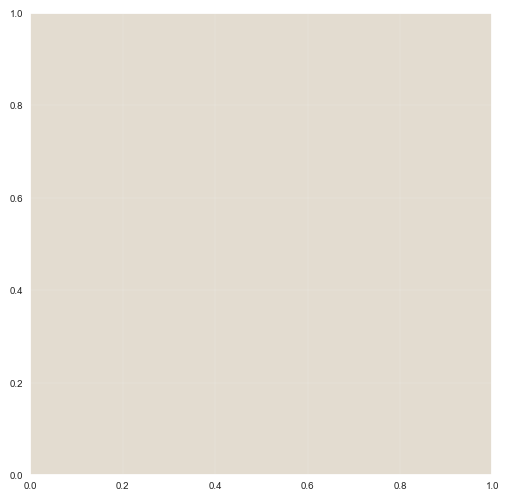

In [2]:
# List of conditions and volumes
conditions = ['k401', 'kif3']
replicates = ['rep1']


# Base directory for data and plots
base_data_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3"
base_plots_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3"

# Iterate over each condition and volume
for condition in conditions:
    for replicate in replicates:
        # Construct the input and output directory paths
        input_dir = f"{base_data_dir}/{condition}/{replicate}/piv_data/PIVlab_****.txt"
        output_dir = f"{base_plots_dir}/{condition}/{replicate}/plots/"

        # Process the PIV files
        dataframes = pivdrops.process_piv_files(input_dir, max_frame=None)

        # Generate time series
        df = pivdrops.piv_time_series(dataframes, time_interval_seconds=3)

        # List of feature names to plot
        features_to_plot = ['velocity', 'power', 'distance', 'work']

        # Plot the time series
        for feature in features_to_plot:
            pivdrops.plot_time_series(df, feature, output_dir=output_dir, sigma=0.5)

        pivdrops.generate_heatmaps(dataframes, 'magnitude [um/s]', vmin=0, vmax=10, output_dir_base=output_dir) 
        pivdrops.generate_heatmaps(dataframes, 'vorticity [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir)
        pivdrops.generate_heatmaps(dataframes, 'divergence [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir) 
        pivdrops.generate_heatmaps(dataframes, 'dcev [1]', vmin=0, vmax=250, output_dir_base=output_dir) 
        pivdrops.generate_heatmaps(dataframes, 'simple shear [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir) 
        pivdrops.generate_heatmaps(dataframes, 'simple strain [1/s]', vmin=-0.03, vmax=0.03, output_dir_base=output_dir) 
        pivdrops.generate_heatmaps(dataframes, 'vector direction [degrees]', vmin=-180, vmax=180, output_dir_base=output_dir) 


In [ ]:
import os
import glob
import sys
import pandas as pd
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()
from natsort import natsorted  # Import for natural sorting
import cv2
import os
import re
from PIL import Image, ImageEnhance, ImageOps  # Added ImageOps here


def sorted_alphanumeric(data):
    """
    Helper function to sort data in human-readable alphanumeric order.
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def make_movies_from_features(base_directory, fps):
    # Find all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

    for feature in subdirectories:
        feature_directory = os.path.join(base_directory, feature)
        output_filename = os.path.join(base_directory, f"{feature}.avi")

        # Get all the .jpg files from the feature directory
        images = [img for img in os.listdir(feature_directory) if img.endswith(".jpg")]

        # Skip if no images are found
        if not images:
            print(f"No images found in {feature_directory}, skipping movie creation.")
            continue

        # Sort the images in alphanumeric order
        images = sorted_alphanumeric(images)

        # Read the first image to get the width and height
        frame = cv2.imread(os.path.join(feature_directory, images[0]))
        height, width, layers = frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

        # Loop through all the images and add them to the video
        for image in images:
            frame = cv2.imread(os.path.join(feature_directory, image))
            out.write(frame)

        # Release everything when the job is finished
        out.release()

def save_dataframes(dataframes, output_dir, prefix='df'):
    """Saves a list of DataFrames to the specified directory."""
    dataframes_dir = os.path.join(output_dir, 'dataframes')
    os.makedirs(dataframes_dir, exist_ok=True)

    for i, df in enumerate(dataframes):
        df_path = os.path.join(dataframes_dir, f'{prefix}_{i}.csv')
        df.to_csv(df_path, index=False)

def load_dataframes(output_dir, prefix='df'):
    """Loads DataFrames from the specified directory."""
    dataframes_dir = os.path.join(output_dir, 'dataframes')
    if not os.path.exists(dataframes_dir):
        return None

    df_files = sorted(glob.glob(os.path.join(dataframes_dir, f'{prefix}_*.csv')))
    if not df_files:
        return None

    return [pd.read_csv(df_file) for df_file in df_files]

def convert_images(input_dir, output_dir, max_frame=None, brightness_factor=1, contrast_factor=1):
    """Converts and adjusts images from input_dir and saves them in output_dir."""
    os.makedirs(output_dir, exist_ok=True)
    input_files = natsorted(glob.glob(os.path.join(input_dir, '*.jpg')))

    if max_frame is not None:
        input_files = input_files[:max_frame]

    output_files = natsorted(glob.glob(os.path.join(output_dir, '*.tif')))

    if len(input_files) == len(output_files):
        print(f"Conversion already completed for {output_dir}. Skipping...")
        return

    num_digits = len(str(len(input_files)))

    for i, file_name in enumerate(input_files):
        image = Image.open(file_name).convert("L")
        image_resized = image.resize((2048, 2048), Image.LANCZOS)

        # Adjust brightness
        enhancer = ImageEnhance.Brightness(image_resized)
        image_brightened = enhancer.enhance(brightness_factor)

        # Adjust contrast
        enhancer = ImageEnhance.Contrast(image_brightened)
        image_contrasted = enhancer.enhance(contrast_factor)

        padded_index = str(i + 1).zfill(num_digits)
        base_file_name = f'converted_image_{padded_index}.tif'
        processed_image_path = os.path.join(output_dir, base_file_name)
        image_contrasted.save(processed_image_path, format='TIFF', compression='tiff_lzw')


def combine_timeseries_dataframes(base_data_dir, conditions, subconditions):
    """
    Combines time series dataframes from multiple conditions and subconditions into a single dataframe.

    This function iterates through specified conditions and subconditions, locating corresponding time series dataframes in a structured directory hierarchy. Each found dataframe is read and a new column 'Condition' is added to it, concatenating the condition and subcondition names. These dataframes are then concatenated into a single dataframe.

    The function assumes a specific file structure and naming convention, where time series dataframes are stored in 'plots/dataframes' subdirectory of each condition and subcondition directory, and are named 'timeseries_df_0.csv'.

    Args:
        base_data_dir (str): The base directory path where the condition and subcondition directories are located.
        conditions (list of str): A list of condition names. Each condition corresponds to a directory under the base data directory.
        subconditions (list of str): A list of subcondition names. Each subcondition corresponds to a subdirectory under each condition directory.

    Returns:
        pd.DataFrame: A combined dataframe containing all the time series data, with an additional 'Condition' column indicating the source condition and subcondition of each row.
    """
    combined_df = pd.DataFrame()

    for condition in conditions:
        for subcondition in subconditions:
            file_path = os.path.join(base_data_dir, condition, subcondition, 'plots', 'dataframes', 'timeseries_df_0.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['Condition'] = f'{condition} {subcondition}'
                combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df


def process_piv_workflow(
        conditions, 
        subconditions, 
        base_data_dir, 
        feature_limits, 
        time_interval, 
        max_frame=None, 
        volume_ul=2, 
        brightness_factor=0.8, 
        contrast_factor=0.8
        ):
    """
    Main workflow to process PIV data.
    
    Args:
    - conditions (list of str): List of conditions.
    - subconditions (list of str): List of subconditions.
    - base_data_dir (str): Base directory for the data.
    - time_intervals (list of int): List of time intervals in seconds, corresponding to each condition.
    - max_frame (int, optional): Maximum number of frames to process.
    - volume_ul (int): Volume in microliters.
    - brightness_factor (float): Factor for brightness adjustment.
    - contrast_factor (float): Factor for contrast adjustment.
    """

    
    for i, condition in enumerate(conditions):
        for subcondition in subconditions:
            # Define directories
            input_image_dir = os.path.join(base_data_dir, condition, subcondition, "piv_movie")
            output_image_dir = os.path.join(base_data_dir, condition, subcondition, "piv_movie_8bit_2048x2048")
            output_dir = os.path.join(base_data_dir, condition, subcondition, "plots")

            # Convert images if not already done
            convert_images(input_image_dir, output_image_dir, max_frame, brightness_factor, contrast_factor)

            # Process PIV files
            input_dir = os.path.join(base_data_dir, condition, subcondition, "piv_data", "PIVlab_****.txt")

            # Process PIV files if not already done
            if not os.path.exists(os.path.join(output_dir, 'dataframes')):
                dataframes = pivdrops.process_piv_files(input_dir, volume=volume_ul, max_frame=max_frame)
                save_dataframes(dataframes, output_dir)

            # Load all dataframes
            dataframes_dir = os.path.join(output_dir, 'dataframes')
            dataframe_files = os.listdir(dataframes_dir)
            dataframes = [pd.read_csv(os.path.join(dataframes_dir, f)) for f in dataframe_files[:max_frame]]

            # Process time series data if not already done
            timeseries_df_path = os.path.join(output_dir, 'dataframes', 'timeseries_df_0.csv')
            
            # Process time series data with the specific time interval
            if not os.path.exists(timeseries_df_path):
                df = pivdrops.piv_time_series(dataframes, time_interval_seconds=time_interval)
                save_dataframes([df], output_dir, prefix='timeseries_df')
            else:
                df = pd.read_csv(timeseries_df_path)

            # Generate heatmaps for each feature
            for feature, (vmin, vmax) in feature_limits.items():
                pivdrops.generate_heatmaps(dataframes, feature, vmin=vmin, vmax=vmax, output_dir_base=output_dir, image_path=output_image_dir)


            # Make movies
            make_movies_from_features(output_dir, fps=120)


In [ ]:
feature_limits = {
    'magnitude [um/s]': (0, 0.1),
    # 'vorticity [1/s]': (-0.001, 0.001),
    # 'divergence [1/s]': (-0.001, 0.001),
    # 'dcev [1]': (0, 250),
    # 'simple shear [1/s]': (-0.001, 0.001),
    # 'simple strain [1/s]': (-0.001, 0.001),
    # 'vector direction [degrees]': (-180, 180),
}

# Example usage
conditions = ['k401']
subconditions = ['rep1']
base_data_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
process_piv_workflow(conditions, subconditions, base_data_dir, feature_limits, time_interval=180, max_frame=120, volume_ul=2)

In [ ]:
feature_limits = {
    'magnitude [um/s]': (0, 4),
    'vorticity [1/s]': (-0.001, 0.001),
    'divergence [1/s]': (-0.001, 0.001),
    'dcev [1]': (0, 250),
    'simple shear [1/s]': (-0.001, 0.001),
    'simple strain [1/s]': (-0.001, 0.001),
    'vector direction [degrees]': (-180, 180),
}

# Example usage
conditions = ['kif3']
subconditions = ['rep1']
base_data_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
process_piv_workflow(conditions, subconditions, base_data_dir, feature_limits, time_interval=3, max_frame=None, volume_ul=2)

In [ ]:
def combine_timeseries_dataframes(base_data_dir, conditions, subconditions):
    combined_df = pd.DataFrame()

    for condition in conditions:
        for subcondition in subconditions:
            file_path = os.path.join(base_data_dir, condition, subcondition, 'plots', 'dataframes', 'timeseries_df_0.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['Condition'] = f'{condition} {subcondition}'
                combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df


conditions = ['k401', 'kif3']
subconditions = ['rep1']
base_data_dir = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
df = combine_timeseries_dataframes(base_data_dir, conditions, subconditions)

for feature in ['velocity', 'power', 'distance', 'work']:
    pivdrops.plot_combined_time_series(df, feature, sigma=1, output_dir=base_data_dir)

Let's make it a package

In [1]:
import sys
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()

velocity_limits = (0, 0.05)
other_limits = (-0.0005, 0.0005)

# velocity_limits = (0, None)
# other_limits = (None, None)

feature_limits = {
    'magnitude [um/s]': velocity_limits,
    'vorticity [1/s]': other_limits,
    'divergence [1/s]': other_limits,
    'dcev [1]': (0, 250),
    'simple shear [1/s]': other_limits,
    'simple strain [1/s]': other_limits,
    'vector direction [degrees]': (-180, 180),
}

# Example usage
conditions = ['k401']
subconditions = ['rep1']
data_path = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
pivdrops.process_piv_data(data_path, max_frame=None, conditions=conditions, subconditions=subconditions, time_interval_seconds=180, feature_limits=feature_limits, frame_rate=120)
pivdrops.plot_combined_timeseries(conditions, subconditions, data_path)


/Users/dalarios/git/activedrops/code/exploratory/../../activedrops/pivdrops.py:316: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ts = pd.concat([df_ts, new_row], ignore_index=True)


In [2]:
import sys
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()

velocity_limits = (0, 3)
other_limits = (-0.05, 0.05)

# velocity_limits = (0, None)
# other_limits = (None, None)

feature_limits = {
    'magnitude [um/s]': velocity_limits,
    'vorticity [1/s]': other_limits,
    'divergence [1/s]': other_limits,
    'dcev [1]': (0, 250),
    'simple shear [1/s]': other_limits,
    'simple strain [1/s]': other_limits,
    'vector direction [degrees]': (-180, 180),
}

# Example usage
conditions = ['kif3']
subconditions = ['rep1']
data_path = "../../data/02-ActiveDROPSfig2-K401_Kif3/"
pivdrops.process_piv_data(data_path, max_frame=None, conditions=conditions, subconditions=subconditions, time_interval_seconds=180, feature_limits=feature_limits, frame_rate=120)
pivdrops.plot_combined_timeseries(conditions, subconditions, data_path)


/Users/dalarios/git/activedrops/code/exploratory/../../activedrops/pivdrops.py:316: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ts = pd.concat([df_ts, new_row], ignore_index=True)
